> **tomato juice dataset**
<br>` 'quality' is the target feature for classification `
<br>` the other features are chemical properties of our product `

**Import the main libraries**

In [1]:
import numpy as np
import pandas as pd

from time import time

_import the local library_

In [2]:
# add parent folder path where lib folder is
import sys
if ".." not in sys.path:import sys; sys.path.insert(0, '..') 

In [3]:
from mylib import show_labels_dist, show_metrics, bias_var_metrics

**Import the Dataset**

In [ ]:
## file path: unix style
df = pd.read_csv('../datasets/tomatjus.csv')

# shape method gives the dimensions of the dataset
print('Dataset dimensions: {} rows, {} columns'.format(
    df.shape[0], df.shape[1]))

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  pulp                  1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


***
**Data Preparation and EDA** (unique to this dataset)
* _Check for missing values_
* _Quick visual check of unique values_
* _Split the classification feature out of the dataset_
* _Check column names of categorical attributes ( for get_dummies() )_
* _Check column names of numeric attributes ( for Scaling )_

**Check for missing values**

In [6]:
cnt=0
print('Missing Values - ')
for col in df.columns:
    nnul = pd.notnull(df[col]) 
    if (len(nnul)!=len(df)):
        cnt=cnt+1
        print('\t',col,':',(len(df)-len(nnul)),'null values')
print('Total',cnt,'features with null values')

# address missing values here

Missing Values - 
Total 0 features with null values


**Quick visual check of unique values, deal with unique identifiers**

In [7]:
# Identify columns with only one value 
# or with number of unique values == number of rows
n_eq_one = []
n_eq_all = []

print('Unique value count (',df.shape[0],'Rows in the dataset )')
for col in df.columns:
    lc = len(df[col].unique())
    print(col, ' ::> ', lc)
    if lc == 1:
        n_eq_one.append(df[col].name)
    if lc == df.shape[0]:
        n_eq_all.append(df[col].name)

Unique value count ( 1599 Rows in the dataset )
fixed acidity  ::>  96
volatile acidity  ::>  143
citric acid  ::>  80
residual sugar  ::>  91
chlorides  ::>  153
free sulfur dioxide  ::>  60
total sulfur dioxide  ::>  144
density  ::>  436
pH  ::>  89
sulphates  ::>  96
pulp  ::>  65
quality  ::>  6


In [8]:
# Drop columns with only one value
if len(n_eq_one) > 0:
    print('Dropping single-valued features')
    print(n_eq_one)
    df.drop(n_eq_one, axis=1, inplace=True)

# Drop or bin columns with number of unique values == number of rows
if len(n_eq_all) > 0:
    print('Dropping unique identifiers')
    print(n_eq_all)
    df.drop(n_eq_all, axis=1, inplace=True)

# continue with featue selection / feature engineering

**<br>Classification target feature**
<br>"the Right Answers", or more formally "the desired outcome"
<br>Must be in a separate dataset for classification ,,,

_Make it a multi-class problem, using text labels_

In [9]:
##  divide into classes by giving a range for quality
##  Make it a multi-class problem: {3,4,5} {6} {7,8}
bins = (2, 5, 6, 8)
group_names = ['Average', 'Premium', 'Special']
df['quality'] = pd.cut(df['quality'], bins = bins, labels = group_names)

* Split the classification feature out of the dataset 

In [10]:
## Feature being predicted ("the Right Answer")
labels_col = 'quality'
y = df[labels_col]

## Features used for prediction 
# pandas has a lot of rules about returning a 'view' vs. a copy from slice
# so we force it to create a new dataframe 
X = df.copy()
X.drop(labels_col, axis=1, inplace=True)

**<br>Check column names of numeric attributes**
<br>Features with numeric values need to be normalised by changing the values to
small numbers in a specific range (scaling). _Note that scaling comes_ after _the test//train split!_

In [11]:
categori = X.select_dtypes(include=['object','category']).columns
print(categori.to_list())

[]


**<br>Check column names of numeric attributes**
<br>Features with numeric values need to be normalised by changing the values to
small numbers in a specific range (scaling). _Note that scaling comes_ after _the test//train split!_

In [12]:
numeri = X.select_dtypes(include=['float64','int64']).columns
print(numeri.to_list())

['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'pulp']


***
**<br>Create Test // Train Datasets**
> Split X and y datasets into Train and Test subsets,<br>keeping relative proportions of each class (stratify)

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=20, 
                                                    stratify=y)
# train_test_split does random selection, 
#      so we should reset the dataframe indexes
X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

***
Next are standard steps for all datasets: _scaling, classifiers, results_

**Scaling** comes _after_ test // train split

In [14]:
# data before normalization
X_train.head()
y_test.head()

0    Special
1    Average
2    Premium
3    Premium
4    Average
Name: quality, dtype: category
Categories (3, object): ['Average' < 'Premium' < 'Special']

In [15]:
# scaling the Numeric columns 
# StandardScaler range: -1 to 1, MinMaxScaler range: zero to 1

# from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# sklearn docs say 
#   "Don't cheat - fit only on training data, then transform both"
#   fit() expects 2D array: reshape(-1, 1) for single col or (1, -1) single row

for i in numeri:
    arr = np.array(X_train[i])
    scale = MinMaxScaler().fit(arr.reshape(-1, 1))
    X_train[i] = scale.transform(arr.reshape(len(arr),1))

    arr = np.array(X_test[i])
    X_test[i] = scale.transform(arr.reshape(len(arr),1))
    

In [16]:
# data after normalization
X_train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,pulp
0,0.238938,0.315068,0.30,0.102740,0.103679,0.208955,0.173145,0.494126,0.566929,0.155689,0.276923
1,0.221239,0.150685,0.28,0.075342,0.117057,0.447761,0.219081,0.504405,0.559055,0.089820,0.153846
2,0.309735,0.311644,0.22,0.082192,0.108696,0.164179,0.208481,0.486784,0.433071,0.107784,0.123077
3,0.557522,0.280822,0.49,0.253425,0.177258,0.134328,0.038869,0.743759,0.259843,0.137725,0.507692
4,0.185841,0.431507,0.01,0.102740,0.110368,0.238806,0.091873,0.398678,0.637795,0.167665,0.676923


**<br>Classifier Selection**

In [17]:
# prepare list
models = []

##  --  Linear  --  ## 
#from sklearn.linear_model import LogisticRegression 
#models.append (("LogReg",LogisticRegression())) 
#from sklearn.linear_model import SGDClassifier 
#models.append (("StocGradDes",SGDClassifier())) 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
models.append(("LinearDA", LinearDiscriminantAnalysis())) 
#from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis 
#models.append(("QuadraticDA", QuadraticDiscriminantAnalysis())) 

##  --  Support Vector  --  ## 
#from sklearn.svm import SVC 
#models.append(("SupportVectorClf", SVC())) 
#from sklearn.svm import LinearSVC 
#models.append(("LinearSVC", LinearSVC())) 
#from sklearn.linear_model import RidgeClassifier
#models.append (("RidgeClf",RidgeClassifier())) 

##  --  Non-linear  --  ## 
#from sklearn.tree import DecisionTreeClassifier 
#models.append (("DecisionTree",DecisionTreeClassifier())) 
#from sklearn.naive_bayes import GaussianNB 
#models.append (("GaussianNB",GaussianNB())) 
#from sklearn.neighbors import KNeighborsClassifier 
#models.append(("K-NNeighbors", KNeighborsClassifier())) 

##  --  Ensemble: bagging  --  ## 
from sklearn.ensemble import RandomForestClassifier 
models.append(("RandomForest", RandomForestClassifier())) 
##  --  Ensemble: boosting  --  ## 
#from sklearn.ensemble import AdaBoostClassifier 
#models.append(("AdaBoost", AdaBoostClassifier())) 
#from sklearn.ensemble import GradientBoostingClassifier 
#models.append(("GradientBoost", GradientBoostingClassifier())) 

##  --  NeuralNet (simplest)  --  ## 
#from sklearn.linear_model import Perceptron 
#models.append (("SingleLayerPtron",Perceptron())) 
#from sklearn.neural_network import MLPClassifier 
#models.append(("MultiLayerPtron", MLPClassifier()))

print(models)

[('LinearDA', LinearDiscriminantAnalysis()), ('RandomForest', RandomForestClassifier())]


**<br>Target Label Distributions** (standard block)

In [18]:
# from our local library
show_labels_dist(X_train,X_test,y_train,y_test)

features_train: 1279 rows, 11 columns
features_test:  320 rows, 11 columns

labels_train: 1279 rows, 1 column
labels_test:  320 rows, 1 column

Frequency and Distribution of labels
         quality  %_train  quality  %_test
quality                                   
Average      595    46.52      149   46.56
Premium      510    39.87      128   40.00
Special      174    13.60       43   13.44


**<br>Fit and Predict** (standard block)

In [19]:
# evaluate each model in turn
results = []

print('macro average: unweighted mean per label')
print('weighted average: support-weighted mean per label')
print('MCC: correlation between prediction and ground truth')
print('     (+1 perfect, 0 random prediction, -1 inverse)\n')

for name, clf in models:
    trs = time()
    print('Confusion Matrix:', name)
    
    clf.fit(X_train, y_train)
    ygx = clf.predict(X_test)
    results.append((name, ygx))
    
    tre = time() - trs
    print ("Run Time {} seconds".format(round(tre,2)) + '\n')
    
# Easy way to ensure that the confusion matrix rows and columns
#   are labeled exactly as the classifier has coded the classes
#   [[note the _ at the end of clf.classes_ ]]

    show_metrics(y_test, ygx, clf.classes_)   # from our local library
    print('\nParameters: ', clf.get_params(), '\n\n')

macro average: unweighted mean per label
weighted average: support-weighted mean per label
MCC: correlation between prediction and ground truth
     (+1 perfect, 0 random prediction, -1 inverse)

Confusion Matrix: LinearDA
Run Time 0.0 seconds

               pred:Average  pred:Premium  pred:Special
train:Average           111            35             3
train:Premium            49            70             9
train:Special             0            28            15

~~~~
     Average :  FPR = 0.287   FNR = 0.255
     Premium :  FPR = 0.328   FNR = 0.453
     Special :  FPR = 0.043   FNR = 0.651

   macro avg :  FPR = 0.219   FNR = 0.453
weighted avg :  FPR = 0.194   FNR = 0.388

~~~~
              precision    recall  f1-score   support

     Average      0.694     0.745     0.718       149
     Premium      0.526     0.547     0.536       128
     Special      0.556     0.349     0.429        43

    accuracy                          0.613       320
   macro avg      0.592     0.547   

**Bias - Variance Decomposition** (standard block)

In [20]:
# from our local library
# reduce (cross-validation) folds for faster results
folds = 7
for name, clf in models:
    print('Bias // Variance Decomposition:', name)
    bias_var_metrics(X_train,X_test,y_train,y_test,clf,folds)

Bias // Variance Decomposition: LinearDA
   Average bias: 0.391
   Average variance: 0.052
   Average expected loss: 0.396  "Goodness": 0.604

Bias // Variance Decomposition: RandomForest
   Average bias: 0.331
   Average variance: 0.105
   Average expected loss: 0.346  "Goodness": 0.654



***
**<br>Visualisations**

In [21]:
import matplotlib.pyplot as plt

* Class Balance

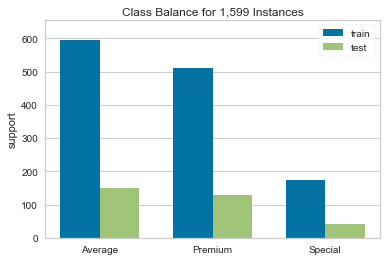

In [22]:
from yellowbrick.target import ClassBalance
# The ClassBalance visualizer has a “compare” mode, 
#   to create a side-by-side bar chart instead of a single bar chart 

# Instantiate the visualizer
visualizer = ClassBalance()
visualizer.fit(y_train, y_test)        # Fit the data to the visualizer
_ = visualizer.show()                  # Finalize and render the figure
# assign visualizer.show() to a null variable to avoid printing some trash

 ***
 **_These examples only work with one classifier_** for example
>models[0][1]  <br>models[1][1]  <br>models[2][1]
 ***

* Confusion matrix _(there are many alternatives)_<br>A "normalised" confusion matrix shows percentages rather than quantity

<function matplotlib.pyplot.show(close=None, block=None)>

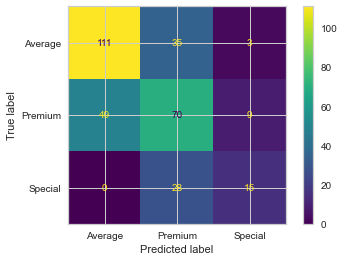

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, results[0][1])
plt.show

In [24]:
# import matplotlib.pyplot as plt
#from scikitplot.metrics import plot_confusion_matrix as splot_cm
#splot_cm(y_test, results[0][1], normalize=False)
#plt.show()

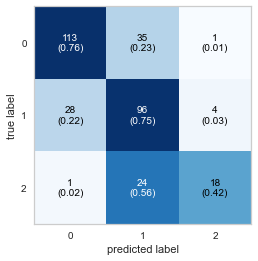

In [25]:
# mlextend confusion_matrix can show one or both

# import matplotlib.pyplot as plt
from mlxtend.evaluate import confusion_matrix as mlx_cnfmtx
from mlxtend.plotting import plot_confusion_matrix

cnfmat = mlx_cnfmtx(y_test, results[1][1])
fig, ax = plot_confusion_matrix(conf_mat=cnfmat,
                                show_absolute=True,
                                show_normed=True,
#                                colorbar=True,
                                figsize=(4, 4))
plt.show()